# Simulations: sythetic profiles with moving shoulder

RICG does not see the static shoulder in persistence profiles. This fact suggests the shoulder to change the radial position. The movement may case the "averaged" spectrogram to be blured.

## Imports

In [235]:

import SimulateGroupDelayDispersive as gd_sim
import matplotlib.mlab as mlab

import numpy as np
import sys
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dd

del_path = '/afs/ipp-garching.mpg.de/home/e/eseliuni/RICcodes/ric_latest_version/ricglibrary'
try:
    sys.path.remove(del_path)
except:
    pass

# Reviewed ricglibrary from the branch ricglibrary/review
new_path = '/afs/ipp-garching.mpg.de/home/e/eseliuni/RICcodes/riclib_develop/review/ricglibrary'
sys.path.append(new_path)

import ricg_new as ricg
from ricg_new.raw.RawRIF import calc_fb2dg
import random

ImportError: No module named RawRIF

In [111]:
def calculateGroupDelayFromNe(r, ne, b,
                totalx=600, totalfc=600, totaldg=10, f1=30e9,f2=85e9):
    """
    Simulates group delay from density profile:
        Reconstructs refractive index of medium in the radius range and for the given cut off frequencies
        Calculates the group delay for a wave propagating in this medium.
        
    Returns
    ---
    Dictionary with:
        'r'
        'ne'
        'b'
        'fc'
        'N'
        'delay'
        'phase'
    """
    

    # Create cut off frequency array
    fc = np.linspace(f1,f2,totalfc)
    
    # Interpolate the density and magnetic profiles to the number of x points 
    newr = np.linspace(r[0],r[-1],totalx)
    ne = np.interp(newr,r,ne)
    b = np.interp(newr,r,b)
    r = newr

    
    # Calculate the refractive index matrix
    N  = gd_sim.createRefractiveMatrix(r, ne, b, fc)

    phase = gd_sim.calc_phase(r,fc,N)

    delay = gd_sim.calc_delay(fc,phase)
    #print delay

    dp_fc, dp_dg = calcXmodeUpperCutoff(fc, delay, ne_ff=0)
    
    out = dict(
            r=r,
            ne=ne,
            b=b,
            fc=fc,
            N=N,
            delay=delay,
            phase=phase,
            dp_fc=dp_fc,
            dp_dg=dp_dg
            )
    return out


def calcXmodeUpperCutoff(fc, delay, ne_ff=0):
    """
        Calculates the upper cut off group delay from the original group delay measurement
    """

    ff = gd_sim.estimate_ff(fc,delay)
    fce0 = gd_sim.estimate_fce0(fc,delay)
    fce0 = gd_sim.estimate_residualfce0(ff,ne_ff)

    dp_fc,dp_dg = gd_sim.calc_ReflectionSignal(fc,delay,ff)
    
    return dp_fc, dp_dg

In [149]:
def bfield(x):
    return 0.6*x + 1.47

In [135]:
def prof(x):
    p = np.poly1d([200, 0, 0])
    return p(x)

In [140]:
def gauss_prof(x, mu = 0.04, variance = 0.0001):
    sigma = np.sqrt(variance)
    gauss = mlab.normpdf(x, mu, sigma)
    return gauss/np.max(gauss)

Assume the SOL profile has a quadratic shape

(0, 2)

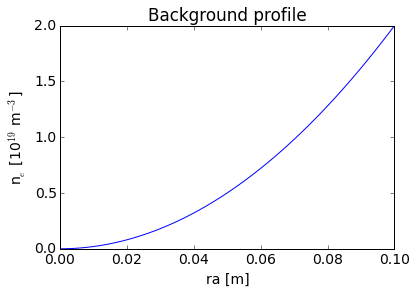

In [138]:
los_ra = np.linspace(0, 0.1, 100)
ne_background = prof(los_ra)

plt.plot(los_ra,ne_background)
plt.title("Background profile")
plt.xlabel("ra [m]")
plt.ylabel(r"n$_e$ [10$^{19}$ m$^{-3}$]")
plt.xlim([0, 0.1])
plt.ylim([0, 2])

Assume the perturbation has a gaussian shape

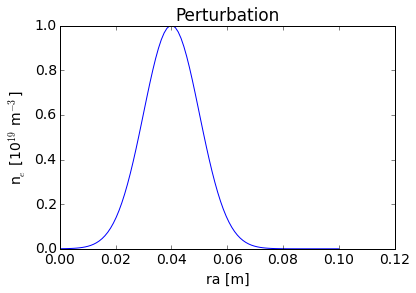

In [164]:
mu = 0.04
variance = 0.0001
ne_perturbation = gauss_prof(los_ra, mu=mu, variance=variance)

plt.plot(los_ra, ne_perturbation)
plt.title("Perturbation")
plt.xlabel("ra [m]")
plt.ylabel(r"n$_e$ [10$^{19}$ m$^{-3}$]")
plt.show()

### Perturbed profile (profile with shoulder)

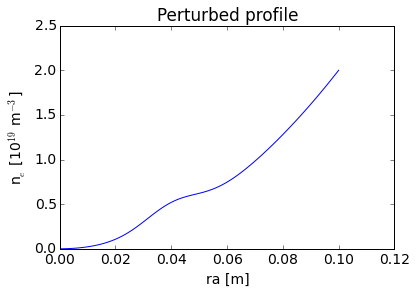

In [146]:
ne_perturbed = ne_background + ne_perturbation*0.2

plt.plot(los_ra, ne_perturbed)
plt.title("Perturbed profile")
plt.xlabel("ra [m]")
plt.ylabel(r"n$_e$ [10$^{19}$ m$^{-3}$]")
plt.show()

### B filed profile

Assume the B field profile to be

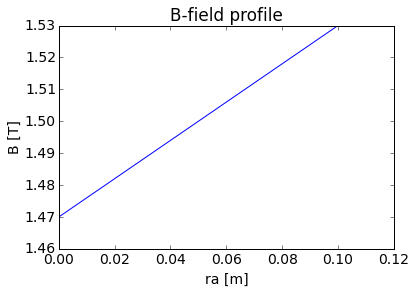

In [150]:
B = bfield(los_ra)

plt.plot(los_ra, B)
plt.title("B-field profile")
plt.xlabel("ra [m]")
plt.ylabel(r"B [T]")
plt.show()

Make a random movement of the profile withing range of 0.02 and 0.08

In [193]:
mu_lst = []
for _ in range(40):
    mu_lst.append(random.uniform(0.02, 0.08))

In [194]:
ne_perturbed_lst = []
for mu in mu_lst:
    ne_perturbation = gauss_prof(los_ra, mu=mu, variance=variance)
    if mu > 0.06:
        a = 0.2
    else: 
        a = 0.3
    ne_perturbed_lst.append(ne_background + ne_perturbation*a)
    #plt.plot(los_ra, ne_background + ne_perturbation*a)

### 40 profiles with different (random from 0.02 to 0.08) shoulder positions

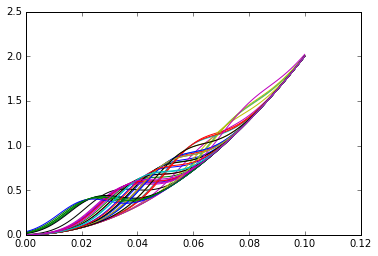

In [200]:
for ne_perturbed in ne_perturbed_lst:
    plt.plot(los_ra, ne_perturbed)

### Symulate the group delay out of the profiles

<span style="color:red; font-family:Georgia; font-size:1.5em;">WORNING!</span> next block takes a lot of time to calculate

In [ ]:
data_lst = []
for ne_perturbed in ne_perturbed_lst:
    data = calculateGroupDelayFromNe(los_ra, ne_perturbed*1e19, B,  totalx=2996, totalfc=2996, f1=40e9, f2=70e9)
    data_lst.append(data)

Calculating refractive matrix 	 28 %

### Obtain the synthetic signal and calculate the spectrogram

In [205]:
stft_lst = []
for data in data_lst:
    N = data['N']
    dp_fc = data['dp_fc']
    dp_dg = data['dp_dg']
    fc = data['fc']
    delay = data['delay']
    r = data['r']
    b = data['b']
    ne = data['ne']

    sweeprate = 28e9/15e-6
    phase = calcRawSignalFromDelay(delay,sweeprate=sweeprate)
    amplitude = 1
    signal = amplitude * np.exp(1j*phase)

    stft_pf, stft_fb, stft = ricg.stft(fc,signal,Fs=200e6,padding=2048,step=10,window=214,windowtype=3)
    stft_lst.append(stft)
stft_lst = np.asarray(stft_lst)

Sum up the spectrogram

In [218]:
stft_sum = np.ndarray.sum(stft_lst, axis=0)

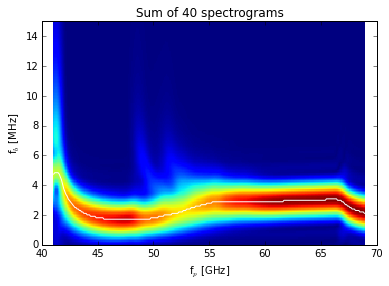

In [231]:
plt.pcolormesh(stft_pf/1e9, stft_fb/1e6, stft_sum)
plt.plot(pk_pf/1e9, pk_fb/1e6, c="white")
plt.title("Sum of 40 spectrograms")
plt.xlabel(r"f$_p$ [GHz]")
plt.ylabel(r"f$_b$ [MHz]")
plt.ylim(0,15)
plt.show()

### Profile reconstruction

In [241]:
shot = ricg.RICG(shotnumber=34290,antenna=1,time=2, 
               persistence=1)

In [242]:

pk_pf, pk_fb, pk_amp = ricg.calcPeakBeatFrequencies(stft_pf,stft_fb,stft_sum)
pk_dg = shot.calc_fb2dg(pk_fb)
pr_re, pr_ne, pr_br = gd_sim.calc_invertProfile(pk_pf, pk_dg, r, b)

Inverting Profile 	 100 % 


/afs/ipp-garching.mpg.de/home/e/eseliuni/RICcodes/ric_newstructure/ricglibrary/SimulateGroupDelayDispersive.py:114: RuntimeWarning: invalid value encountered in sqrt
  fpe[0] = np.sqrt(np.power(fc[0],2)-fc[0]*fce[0])


## Final results

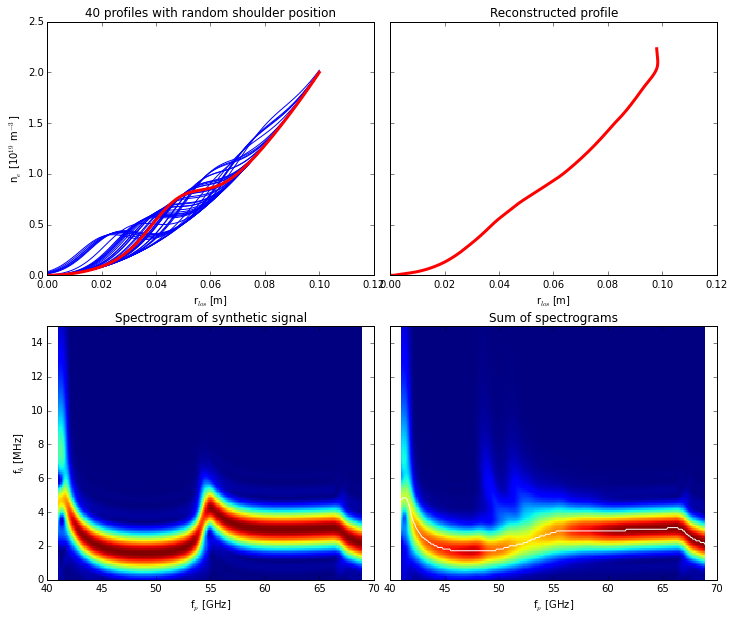

In [260]:
fig, ax = plt.subplots(2,2, sharex='row', sharey="row", figsize=(12,10))
fig.subplots_adjust(wspace=0.05)

for ne_perturbed in ne_perturbed_lst:
    ax[0,0].plot(los_ra, ne_perturbed, c="blue")

ax[0,0].plot(los_ra, ne_perturbed_lst[0], c="red", lw=3)
ax[0,0].set_title("40 profiles with random shoulder position")
ax[0,0].set_ylabel(r"n$_e$ [10$^{19}$ m$^{-3}$]")
ax[0,0].set_xlabel(r"r$_{los}$ [m]")

ax[1,0].pcolormesh(stft_pf/1e9, stft_fb/1e6, stft_lst[0,:,:])
ax[1,0].set_title("Spectrogram of synthetic signal")
ax[1,0].set_ylabel(r"f$_b$ [MHz]")
ax[1,0].set_xlabel(r"f$_p$ [GHz]")
ax[1,0].set_ylim(0,15)

ax[0,1].plot(pr_re, pr_ne*1e-19, c="r", lw=3)
ax[0,1].set_title("Reconstructed profile")
ax[0,1].set_xlabel(r"r$_{los}$ [m]")

ax[1,1].pcolormesh(stft_pf/1e9, stft_fb/1e6, stft_sum)
ax[1,1].plot(pk_pf/1e9, pk_fb/1e6, c="white")
ax[1,1].set_title("Sum of spectrograms")
ax[1,1].set_xlabel(r"f$_p$ [GHz]")

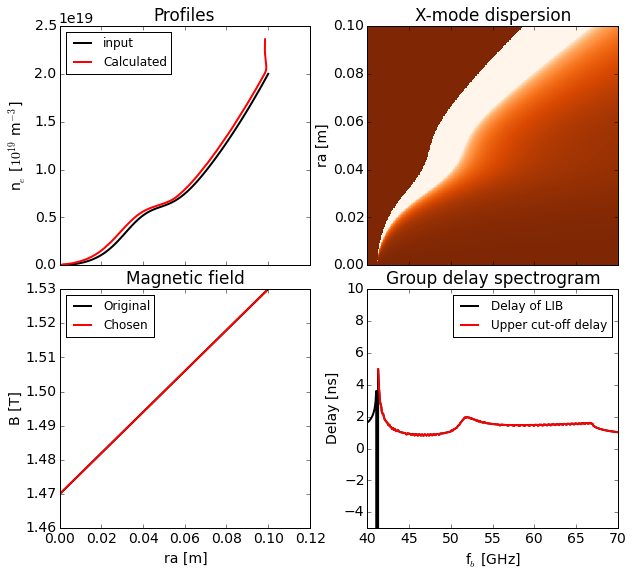

In [153]:
fig,axarr = plt.subplots(2,2, figsize=(10,9), dpi=800, sharex='col')
fig.subplots_adjust(hspace=.1, wspace=.23)
matplotlib.rcParams.update({'font.size': 14})
colornorm = colors.Normalize(vmin=0,vmax=1)

ax = axarr[0,0]

ax.plot(los_ra,ne_perturbed*1e19, label="input", lw=2, color="k")
ax.plot(pr_re,pr_ne, label="Calculated", lw=2, color="r")
ax.set_title('Profiles')
ax.set_ylabel(r"n$_e$ [$10^{19}$ m$^{-3}$]")
ax.legend(loc=2, fontsize=12)

ax = axarr[0,1]
ax.pcolormesh(fc/1e9,r,N.T, cmap='Oranges',norm=colornorm)
ax.set_ylabel('ra [m]')
ax.set_title('X-mode dispersion')
ax.set_ylim([r.min(),r.max()])


ax = axarr[1,0]
ax.plot(r, b, label="Original", c='k', lw=2)
ax.plot(pr_re, pr_br, c='r', label="Chosen", lw=2)
ax.set_xlabel(r"ra [m]")
ax.set_ylabel(r"B [T]")
ax.set_title('Magnetic field')
ax.set_xlim([r.min(),r.max()+0.02])
ax.legend(loc='best', fontsize=12)

ax = axarr[1,1]
ax.plot(fc/1e9,delay*1e9,"k", lw=2, label='Delay of LIB')
ax.plot(dp_fc/1e9, dp_dg*1e9, "r",lw=2, label='Upper cut-off delay')
ax.set_xlabel(r"f${_b}$ [GHz]")
ax.set_ylabel(r"Delay [ns]")
ax.legend(loc='best', fontsize=12)
ax.set_title('Group delay spectrogram')

plt.ylim([-5,10])
plt.xlim([40,70])


plt.show()


In [154]:
def calcRawSignalFromDelay(delay,sweeprate=28e9/15e-6,fs=200e6):
    
    fb = delay*sweeprate
    phasediff = np.zeros(len(fb))
    
    for i in range(len(delay)):
        phasediff[i] = fb[i]*2*np.pi/fs
    phase = np.cumsum(phasediff)
    phase = np.unwrap(phase)
    return phase